In [1]:
import numpy as np
from numpy.random import randn, rand, seed
from numpy.linalg import norm, inv, solve
import matplotlib.pyplot as plt
import math
import time

In [2]:
def f(x):
    '''
     - input: x, input vector
     - output: f(x)
    '''
    return float(c_vec.T.dot(x) - np.sum(np.log(b - A.dot(x))))

def nabla_f(x):
    '''
     - input: x, input vector
     - output: gradient of f(x)
    '''
    return np.array(c_vec) + np.sum(A / (b - A.dot(x)), 0).reshape(100, 1)

def nabla2_f(x):
    '''
     - input: x, input vector
     - output: hessian of f(x)
    '''
    return (A/((b - A.dot(x))**2)).T.dot(A)

In [3]:
def btls(pk, xk, c, rho):
    '''
    inputs:
        - pk: update vector
        - xk: vector to be updated
        - c, rho: btls parameters
    outputs:
        - alpha: best step size to use for update
    Runs the backtracking line search algorithm and returns an optimal step size
    '''
    alpha = 1
    xk_plus_1 = np.array(xk + alpha*pk)
    while np.min(b-A.dot(xk_plus_1)) <= 0: # iterate until update is inside of Omega
        alpha /= 2
        xk_plus_1 = np.array(xk + alpha*pk)
    while f(xk + alpha*pk) > f(xk) + c*alpha*(-pk.T).dot(pk):
        alpha *= rho # run backtracking line search to satisfy Armijo condition
    return alpha

def sdbtls(x0, e=1e-3, c=.01, rho=.05, max_steps=5000):
    '''
    inputs:
        - x0: initial starting vector
        - e: tolerance level
        - c, rho: btls parameters
        - max_steps: maximum iterations allowed
    outputs:
        - xk: minimizer of f using steepest descent method with
        backtracking line search algorithm
        - fxs: list of values of f(xk) for each iteration
    Runs steepest descent method for a given x0
    '''
    fxs = []
    xk = np.array(x0)
    for _ in range(max_steps):
        pk = -nabla_f(xk) # steepest descent direction
        alpha_k = btls(pk, xk, c, rho) # run backtracking line search to find best step size
        xk = np.array(xk + alpha_k*pk) # update x_k
        fxs.append(f(xk))
        if norm(nabla_f(xk)) < e:
            return xk, fxs
        
    if len(fxs) == 5000:
        print("Steepest descent algorithm failed to converge with parameters: \
e = {}, c = {}, rho = {}".format("%.e" %e , c, rho))
        return None, []
    else:
        return xk, fxs

def newton(x0, e=1e-3, c=.01, rho=.05, max_steps=1000):
    '''
    inputs:
        - x0: initial starting vector
        - e: tolerance level
        - c, rho: btls parameters
        - max_steps: maximum iterations allowed
    outputs:
        - xk: minimizer of f using newton method with
        backtracking line search algorithm
    Runs Newton method for a given x0, after 10 steps of steepest descent
    '''
    xk, fxs = sdbtls(x0, max_steps=10) # Start by running steepest descent for 10 iterations
    for _ in range(max_steps):
        gr = nabla_f(xk)
        gr2 = nabla2_f(xk)
        pk = solve(gr2, -gr) # obtain inverse by solving linearly for pk
        l2 = float(gr.T.dot(-pk)) # newton decrement
        if l2/2 <= e:
            return xk, fxs
        alpha_k = btls(pk, xk, c, rho)
        xk = xk + alpha_k*pk
        fxs.append(f(xk))
    print("Newton algorithm failed to converge") 

## (a) and (b)

Let's run our different methods for 10 random trials to verify if our algorithms work well.

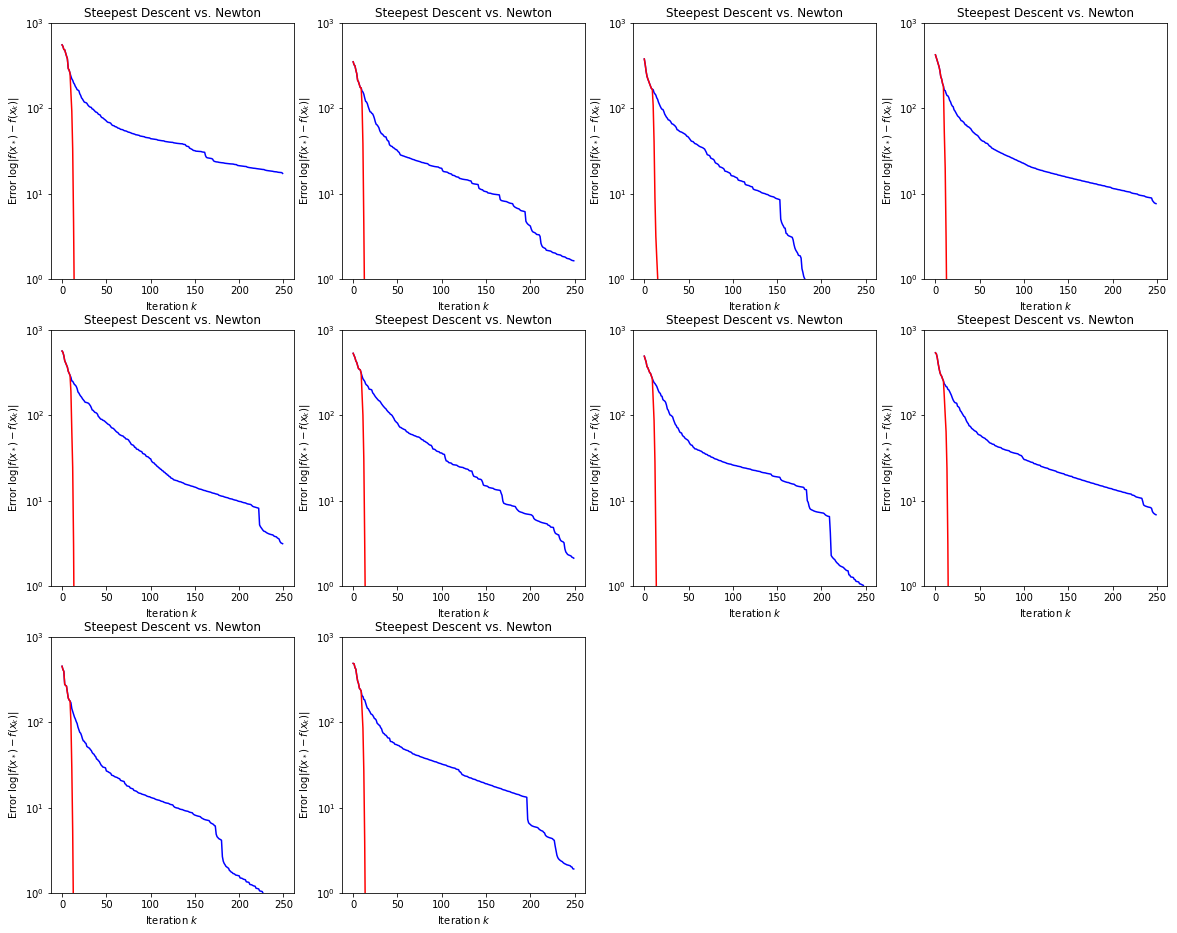

Average number of iterations for Steepest Descent: 1357.80
Average number of iterations for Newton method: 17.30


In [4]:
plt.figure(figsize=(20, 16))
iter_sd = []
iter_n = []
for i in range(10):
    # Generate A, x0, b, c randomly
    A = 100*randn(500, 100)
    x0 = randn(100, 1)
    b = A.dot(x0) + 200*rand(500, 1)
    c_vec = 100*randn(100, 1)
    
    # run steepest descent and newton algorithms
    xk_sd, fxs_sd = sdbtls(x0)
    xk_n, fxs_n = newton(x0)
    if fxs_sd: iter_sd.append(len(fxs_sd))
    iter_n.append(len(fxs_n))
    
    # plot log error for each
    plt.subplot(3, 4, i+1)
    if fxs_sd: plt.plot(abs(np.array(fxs_sd)[:250] - f(xk_sd)), 'b')
    plt.plot(abs(np.array(fxs_n) - f(xk_n)), 'r')
    plt.ylim(1, 1e3)
    plt.yscale('log')
    plt.minorticks_off()
    plt.xlabel(r'Iteration $k$')
    plt.ylabel(r'Error $\log|f(x_*) - f(x_k)|$')
    plt.title(r'Steepest Descent vs. Newton')
plt.show()
print("Average number of iterations for Steepest Descent: %.2f" % np.mean(iter_sd))
print("Average number of iterations for Newton method: %.2f" % np.mean(iter_n))

Since the Newton method converges much quicker (quadratically) than Steepest descent, we use a logarithmic scale in order to reduce significantly this skewness in iterations needed for convergence and compare both curves more easily. It allows us to see how Newton Method takes only 7 additional iterations to converge on average with a tolerance of $10^{-3}$ after 10 iterations of steepest descent while steepest descent alone takes around 1358 iterations to converge.

## (c) and (d)

For this question, I ran each algorithm 10 times using random matrices for each parameter and averaged the numbers of iterations needed to achieve convergence. I also displayed the last run's error vs iteration plot for each parameter. If the algorithm fails to converge to $\vec{x}_*$, I did not plot the error since we need $f(\vec{x}_*)$ for this purpose.

In [5]:
def plot_stats(sd, n, array, string):
    plt.figure(figsize=(20, 11))
    plt.subplot(231)
    plt.plot(array, np.array(sd)[:,0], 'b')
    plt.title('Average duration for Steepest Descent')
    plt.xlabel(string)
    plt.ylabel(r'Duration')
    plt.subplot(232)
    plt.plot(array, np.array(sd)[:,1], 'b')
    plt.title('Average number of Iterations for Steepest Descent')
    plt.xlabel(string)
    plt.ylabel(r'Iterations')
    plt.subplot(233)
    plt.plot(array, np.array(sd)[:,2]/10*100, 'b')
    plt.title('Percentage of convergence for Steepest Descent')
    plt.xlabel(string)
    plt.ylabel(r'%')
    plt.ylim(-9, 109)
    plt.subplot(234)
    plt.plot(array, np.array(n)[:,0], 'r')
    plt.title('Average duration for Newton')
    plt.xlabel(string)
    plt.ylabel(r'Duration')
    plt.subplot(235)
    plt.plot(array, np.array(n)[:,1], 'r')
    plt.title('Average number of Iterations for Newton')
    plt.xlabel(string)
    plt.ylabel(r'Iterations')
    plt.subplot(236)
    plt.plot(array, np.array(n)[:,2]/10*100, 'r')
    plt.title('Percentage of convergence for Newton')
    plt.xlabel(string)
    plt.ylabel(r'%')
    plt.ylim(-9, 109)
    plt.show()

Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.9, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.25, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.5, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.75, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.9, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.25, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.5, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.75, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.9, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.9, rho = 0.05
Steepest descent algorithm failed to converge with param

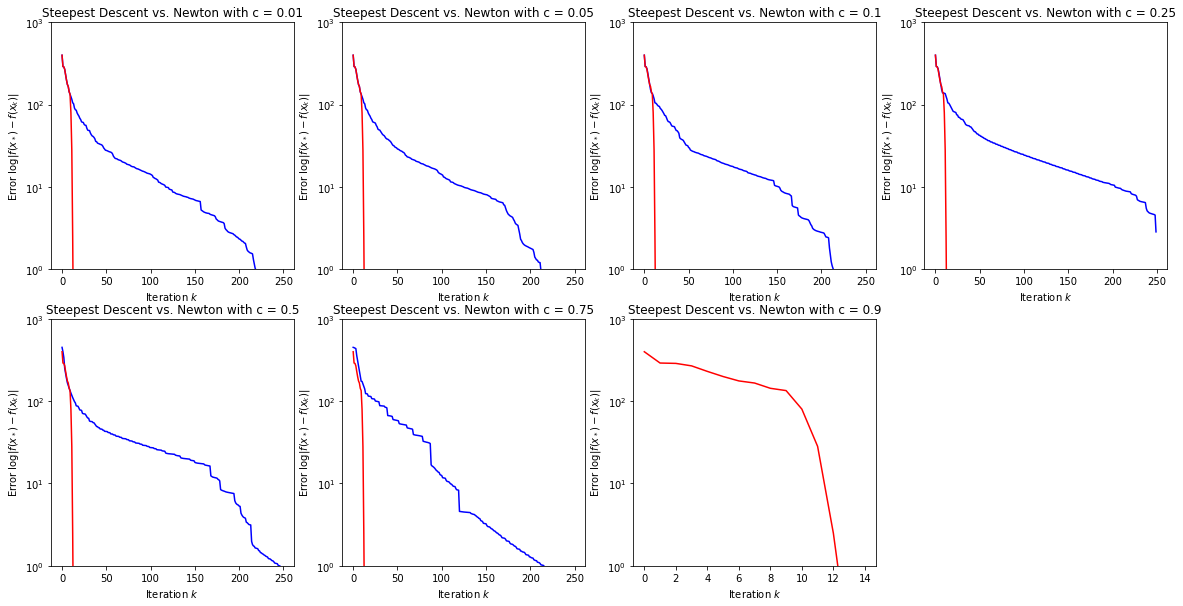

In [6]:
cs = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90]
plt.figure(figsize=(20, 10))
iter_sd = [[] for i in range(len(cs))]
dur_sd = [[] for i in range(len(cs))]
iter_n = [[] for i in range(len(cs))]
dur_n = [[] for i in range(len(cs))]
for k in range(10): #10 different trials
    # Generate A, x0, b, c randomly
    A = 100*randn(500, 100)
    x0 = randn(100, 1)
    b = A.dot(x0) + 200*rand(500, 1)
    c_vec = 100*randn(100, 1)
    for i in range(len(cs)):
        # run steepest descent and newton algorithms, recording time and iterations
        tsd = time.time()
        xk_sd, fxs_sd = sdbtls(x0, c = cs[i])
        if fxs_sd:
            dur_sd[i].append(time.time()-tsd)
            iter_sd[i].append(len(fxs_sd))
        tn = time.time()
        xk_n, fxs_n = newton(x0, c = cs[i])
        dur_n[i].append(time.time()-tn)
        iter_n[i].append(len(fxs_n))
        
        if k == 9: # last trial
            # plot log error
            plt.subplot(2, 4, i+1)
            if fxs_sd: plt.plot(abs(np.array(fxs_sd)[:250] - f(xk_sd)), 'b')
            plt.plot(abs(np.array(fxs_n) - f(xk_n)), 'r')
            plt.ylim(1, 1e3)
            plt.yscale('log')
            plt.minorticks_off()
            plt.xlabel(r'Iteration $k$')
            plt.ylabel(r'Error $\log|f(x_*) - f(x_k)|$')
            plt.title(r'Steepest Descent vs. Newton with c = {}'.format(cs[i]))
plt.show()

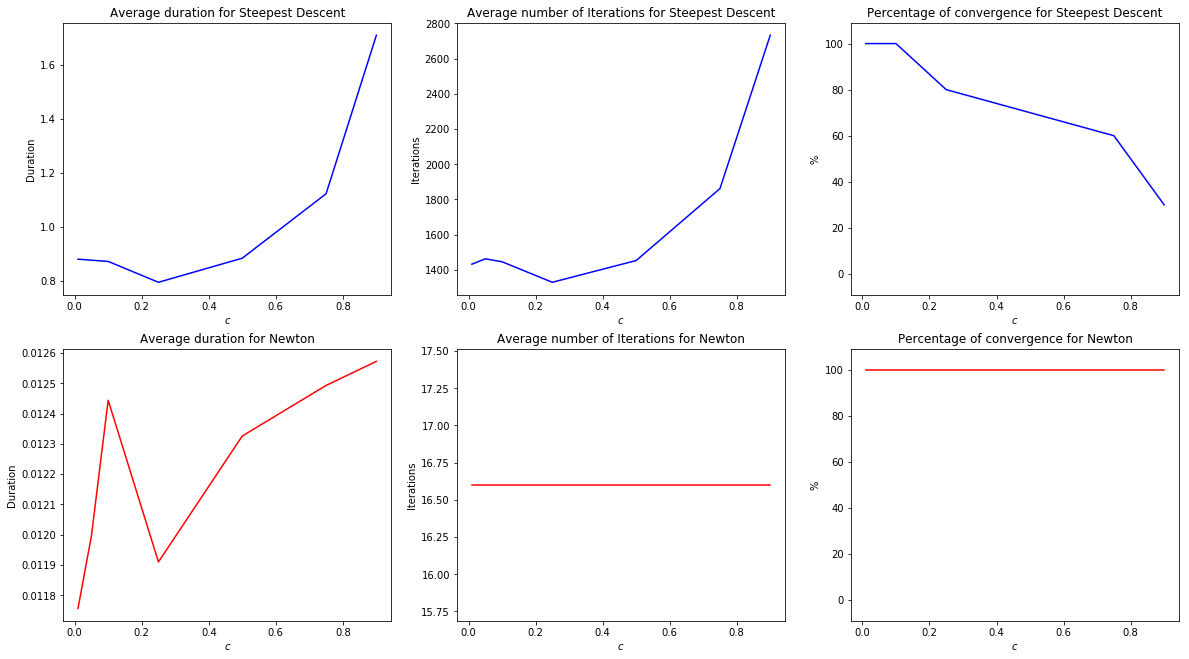

In [7]:
sd = np.array([[np.mean(dur_sd[i]), np.mean(iter_sd[i]), len(dur_sd[i])] for i in range(len(cs))])
n = np.array([[np.mean(dur_n[i]), np.mean(iter_n[i]), len(dur_n[i])] for i in range(len(cs))])
plot_stats(sd, n, cs, r'$c$')

As we can see, the Steepest Descent takes more iterations and more time to converge when the backtracking parameter $c$ increases. Additionally, Steepest Descent is a lot less likely to actually reach convergence as $c$ increases. On the other hand, Newton method's average iterations remains the same as $c$ increases, and the algorithm converges for every case.

Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.01, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.01, rho = 0.5
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.01, rho = 0.75
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.01, rho = 0.95
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.01, rho = 0.75
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.01, rho = 0.95
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.01, rho = 0.95
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.01, rho = 0.75
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.01, rho = 0.95
Steepest descent algorithm failed to converge with parameters: e = 1e-03, c = 0.01, rho = 0.95


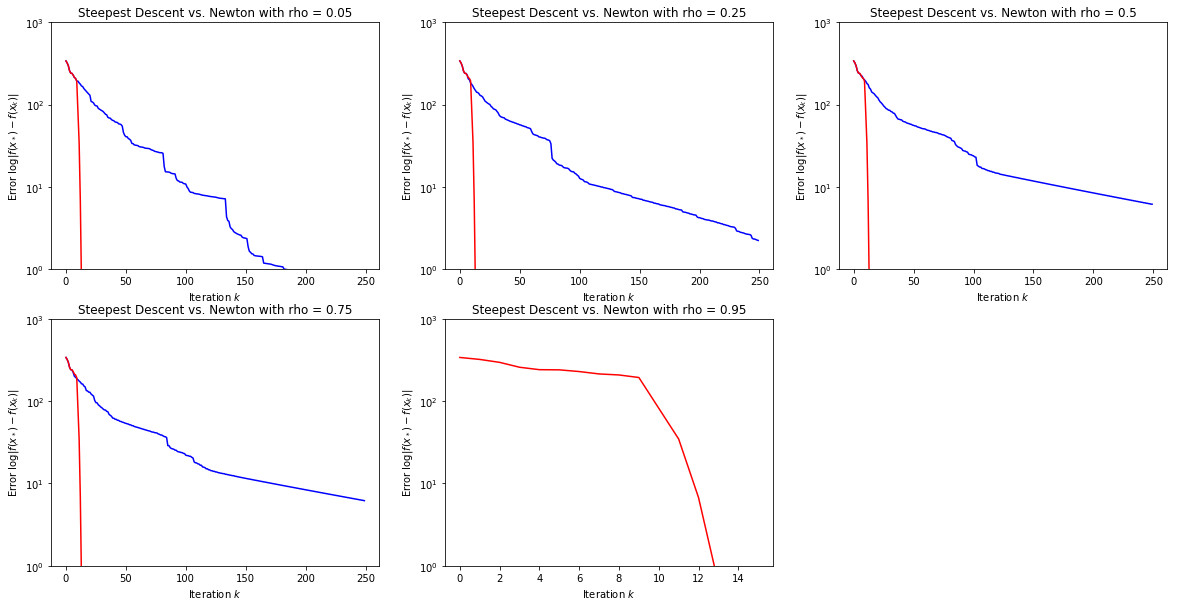

In [8]:
rhos = [0.05, 0.25, 0.50, 0.75, 0.95]
plt.figure(figsize=(20, 10))
iter_sd = [[] for i in range(len(cs))]
dur_sd = [[] for i in range(len(cs))]
iter_n = [[] for i in range(len(cs))]
dur_n = [[] for i in range(len(cs))]
for k in range(10): #10 different trials
    # Generate A, x0, b, c randomly
    A = 100*randn(500, 100)
    x0 = randn(100, 1)
    b = A.dot(x0) + 200*rand(500, 1)
    c_vec = 100*randn(100, 1)
    for i in range(len(rhos)):
        # run steepest descent and newton algorithms, recording time and iterations
        tsd = time.time()
        xk_sd, fxs_sd = sdbtls(x0, rho = rhos[i])
        if fxs_sd:
            dur_sd[i].append(time.time()-tsd)
            iter_sd[i].append(len(fxs_sd))
        tn = time.time()
        xk_n, fxs_n = newton(x0, rho = rhos[i])
        dur_n[i].append(time.time()-tn)
        iter_n[i].append(len(fxs_n))
        
        if k == 9:
            # plot log error for each
            plt.subplot(2, 3, i+1)
            if fxs_sd: plt.plot(abs(np.array(fxs_sd)[:250] - f(xk_sd)), 'b')
            plt.plot(abs(np.array(fxs_n) - f(xk_n)), 'r')
            plt.ylim(1, 1e3)
            plt.yscale('log')
            plt.minorticks_off()
            plt.xlabel(r'Iteration $k$')
            plt.ylabel(r'Error $\log|f(x_*) - f(x_k)|$')
            plt.title(r'Steepest Descent vs. Newton with rho = {}'.format(rhos[i]))
plt.show()

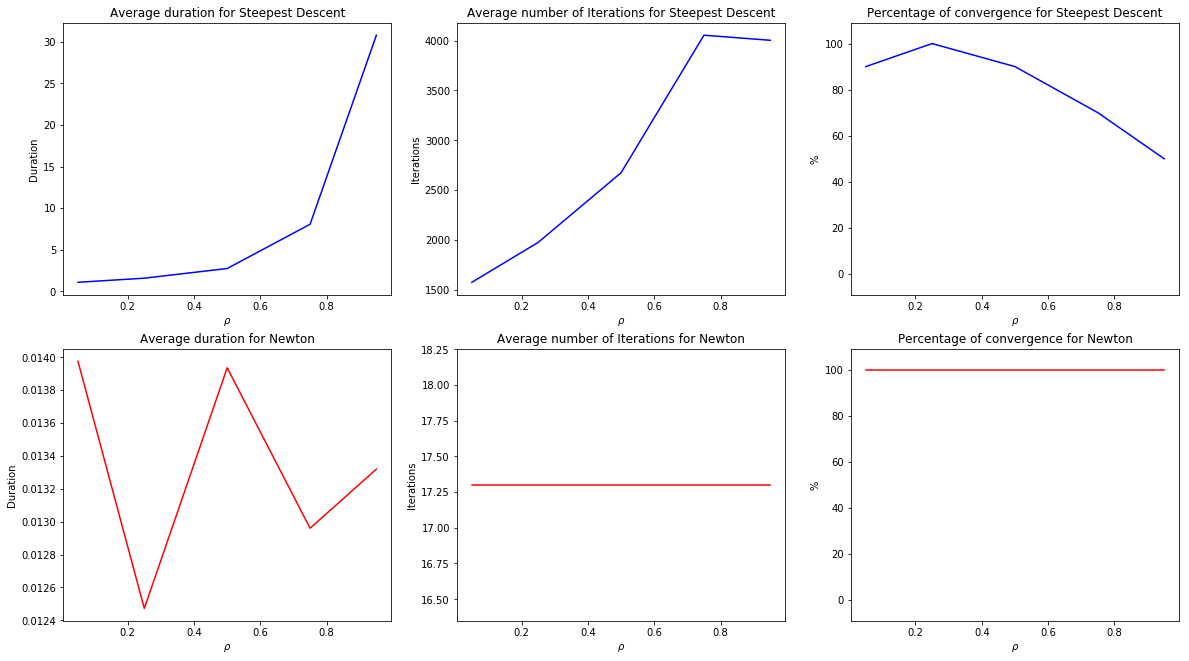

In [9]:
sd = np.array([[np.mean(dur_sd[i]), np.mean(iter_sd[i]), len(dur_sd[i])] for i in range(len(rhos))])
n = np.array([[np.mean(dur_n[i]), np.mean(iter_n[i]), len(dur_n[i])] for i in range(len(rhos))])
plot_stats(sd, n, rhos, r'$\rho$')

Here, I changed the backtracking parameter $\rho$ and repeated the experiment. As we can see, the average number of iterations needed to reach convergence increase as $\rho$ increases for Steepest Descent as well as the time required for convergence, while the iterations remain constant for Newton, and the duration is insignificant. As $\rho$ increases, Steepest Descent is more unlikely to reach convergence, while Newton always converges.

Steepest descent algorithm failed to converge with parameters: e = 1e-05, c = 0.01, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-08, c = 0.01, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-05, c = 0.01, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-08, c = 0.01, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-05, c = 0.01, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-08, c = 0.01, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-05, c = 0.01, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-08, c = 0.01, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-05, c = 0.01, rho = 0.05
Steepest descent algorithm failed to converge with parameters: e = 1e-08, c = 0.01, rho = 0.05
Steepest descent algorithm failed to converge with

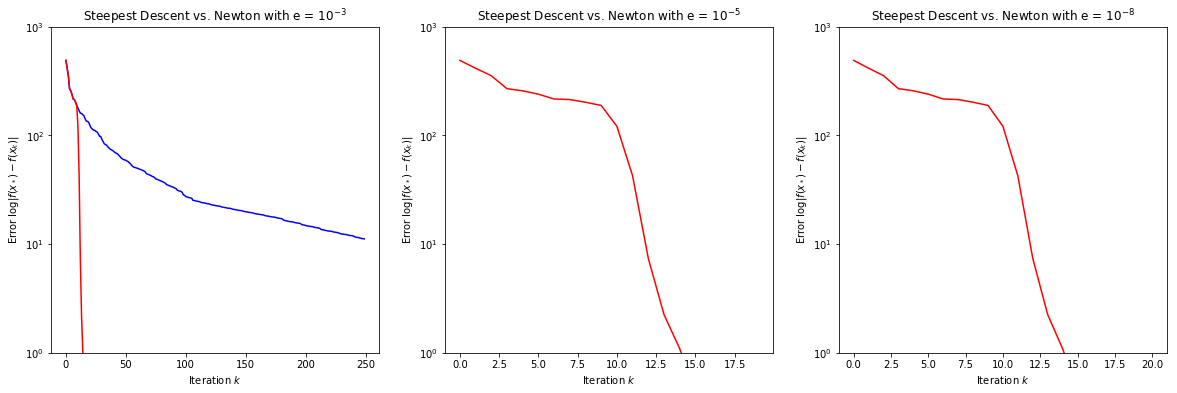

In [10]:
es = [1e-3, 1e-5, 1e-8]
esprint = ['$10^{-3}$', '$10^{-5}$', '$10^{-8}$']
plt.figure(figsize=(20, 6))
iter_sd = [[] for i in range(len(cs))]
dur_sd = [[] for i in range(len(cs))]
iter_n = [[] for i in range(len(cs))]
dur_n = [[] for i in range(len(cs))]
for k in range(10): #10 different trials
    # Generate A, x0, b, c randomly
    A = 100*randn(500, 100)
    x0 = randn(100, 1)
    b = A.dot(x0) + 200*rand(500, 1)
    c_vec = 100*randn(100, 1)
    for i in range(len(es)):
        # run steepest descent and newton algorithms, recording time and iterations
        tsd = time.time()
        xk_sd, fxs_sd = sdbtls(x0, e = es[i])
        if fxs_sd:
            dur_sd[i].append(time.time()-tsd)
            iter_sd[i].append(len(fxs_sd))
        tn = time.time()
        xk_n, fxs_n = newton(x0, e = es[i])
        dur_n[i].append(time.time()-tn)
        iter_n[i].append(len(fxs_n))
        
        if k == 9:
            # plot log error for each
            plt.subplot(1, 3, i+1)
            if fxs_sd: plt.plot(abs(np.array(fxs_sd)[:250] - f(xk_sd)), 'b')
            plt.plot(abs(np.array(fxs_n) - f(xk_n)), 'r')
            plt.ylim(1, 1e3)
            plt.yscale('log')
            plt.minorticks_off()
            plt.xlabel(r'Iteration $k$')
            plt.ylabel(r'Error $\log|f(x_*) - f(x_k)|$')
            plt.title(r'Steepest Descent vs. Newton with e = {}'.format(esprint[i]))
plt.show()

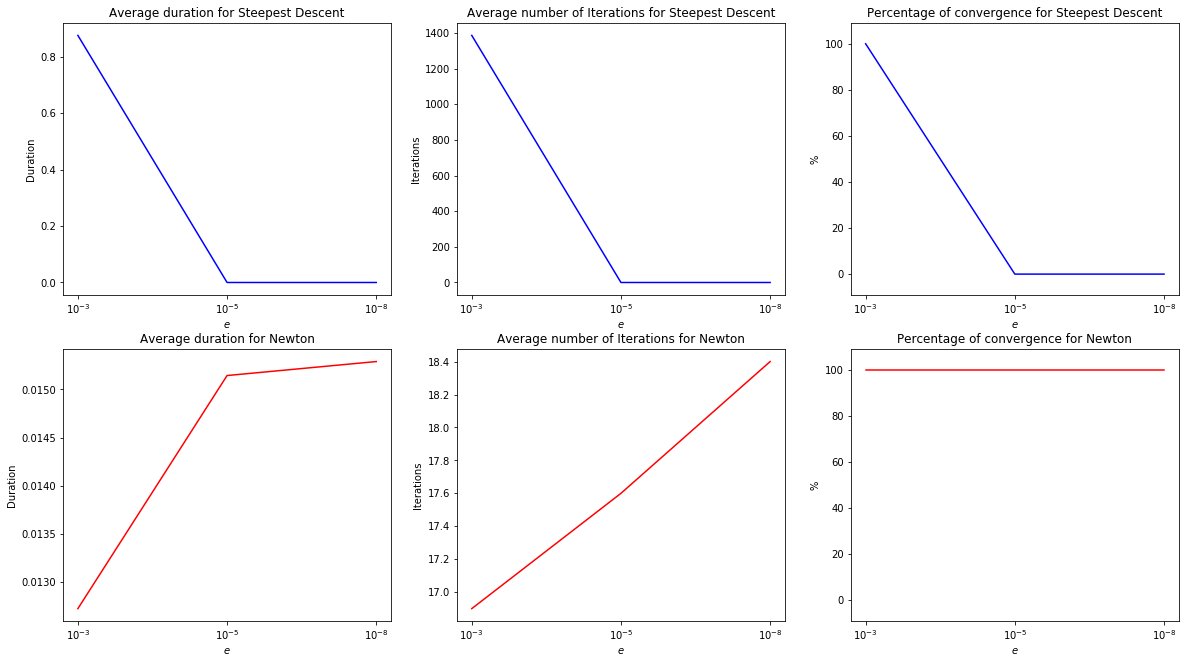

In [11]:
sd = np.array([[np.mean(dur_sd[0]), np.mean(iter_sd[0]), len(dur_sd[0])], [0,0,0], [0,0,0]])
n = np.array([[np.mean(dur_n[i]), np.mean(iter_n[i]), len(dur_n[i])] for i in range(len(es))])
plot_stats(sd, n, esprint, r'$e$')

As we can see, Steepest Descent is unable to converge for $e = 10^{-5}$ and $e = 10^{-8}$. However, we can see logically that Newton Method requires more steps as the tolerance $e$ decreases.

In general, we saw that Newton method successfully converges in every case and uses only less than 20 iterations (the first 10 being steepest descent) to converge. It also takes a lot less time to converge compared to Steepest Descent in general. Although it is less expensive, Steepest Descent takes between 500 and 2000 iterations to converge on average. Additionally, Steepest Descent gets stuck at a precision level of $10^{-3}$ and cannot converge with more precision.

For the same matrix, it is interesting to note that the convergence rate of the Newton method does not depend on the backtracking parameters. The convergence rate remains constant. However, Steepest Descent seems to converge faster as $c$ and $\rho$ are smaller.